In [1]:
# Simple Token Length Analysis for Chess Dataset
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer

# Load your JSON data
with open('/home/jovyan/chessLLM/verl/third_party/SkyThought/skythought/train/LLaMA-Factory/data/original_chess_reasoning.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)
    data = json_data["results"]

print(f"Loaded {len(data)} chess examples")

Loaded 983 chess examples


#### Samples with length > 2000

In [2]:
# Setup tokenizers
print("Loading tokenizers...")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")

def extract_answer_from_output(output_text):
    """Extract just the answer from the output (between <answer> tags)"""
    if '<answer>' in output_text and '</answer>' in output_text:
        start = output_text.find('<answer>') + 8
        end = output_text.find('</answer>')
        return output_text[start:end].strip()
    return output_text.strip()

# Find samples with >2000 tokens
long_samples = {
    'qwen_output': [],
    'qwen_reasoning': [],
    'qwen_combined': [],
    'llama_output': [],
    'llama_reasoning': [],
    'llama_combined': []
}

print("Analyzing each sample...\n")

for i, item in enumerate(data):
    # Extract texts
    output_only = extract_answer_from_output(item['output'])
    reasoning_only = item['reasoning_summary']
    combined = f"{output_only}\n\n{reasoning_only}"
    
    # Tokenize with Qwen
    qwen_output_tokens = len(qwen_tokenizer.encode(output_only))
    qwen_reasoning_tokens = len(qwen_tokenizer.encode(reasoning_only))
    qwen_combined_tokens = len(qwen_tokenizer.encode(combined))
    
    # Tokenize with Llama
    llama_output_tokens = len(llama_tokenizer.encode(output_only))
    llama_reasoning_tokens = len(llama_tokenizer.encode(reasoning_only))
    llama_combined_tokens = len(llama_tokenizer.encode(combined))
    
    # Check for samples >2000 tokens
    if qwen_output_tokens > 2000:
        long_samples['qwen_output'].append((i, qwen_output_tokens))
    if qwen_reasoning_tokens > 2000:
        long_samples['qwen_reasoning'].append((i, qwen_reasoning_tokens))
    if qwen_combined_tokens > 2000:
        long_samples['qwen_combined'].append((i, qwen_combined_tokens))
    if llama_output_tokens > 2000:
        long_samples['llama_output'].append((i, llama_output_tokens))
    if llama_reasoning_tokens > 2000:
        long_samples['llama_reasoning'].append((i, llama_reasoning_tokens))
    if llama_combined_tokens > 2000:
        long_samples['llama_combined'].append((i, llama_combined_tokens))

# Print results
print("🔍 SAMPLES WITH >2000 TOKENS")
print("=" * 80)

for category, samples in long_samples.items():
    tokenizer = "Qwen" if "qwen" in category else "Llama"
    text_type = category.split('_', 1)[1].replace('_', ' ').title()
    
    print(f"\n{tokenizer} - {text_type}:")
    if samples:
        print(f"  Found {len(samples)} samples:")
        for idx, token_count in samples:
            print(f"    Index {idx}: {token_count} tokens")
        
        # Show details for the longest ones
        if len(samples) > 0:
            # Sort by token count (descending)
            samples_sorted = sorted(samples, key=lambda x: x[1], reverse=True)
            longest_idx, longest_tokens = samples_sorted[0]
            
            print(f"\n  📝 LONGEST SAMPLE (Index {longest_idx}, {longest_tokens} tokens):")
            if 'output' in category:
                text_to_show = extract_answer_from_output(data[longest_idx]['output'])
            elif 'reasoning' in category:
                text_to_show = data[longest_idx]['reasoning_summary']
            else:  # combined
                output = extract_answer_from_output(data[longest_idx]['output'])
                reasoning = data[longest_idx]['reasoning_summary']
                text_to_show = f"{output}\n\n{reasoning}"
            
            # Show first 500 characters
            preview = text_to_show[:500] + "..." if len(text_to_show) > 500 else text_to_show
            print(f"    Preview: {repr(preview)}")
    else:
        print("    No samples found with >2000 tokens")

# Create summary table
print("\n" + "=" * 80)
print("SUMMARY TABLE - SAMPLES WITH >2000 TOKENS")
print("=" * 80)

summary_data = []
for category, samples in long_samples.items():
    tokenizer = "Qwen" if "qwen" in category else "Llama"
    text_type = category.split('_', 1)[1].replace('_', ' ').title()
    
    if samples:
        indices = [str(idx) for idx, _ in samples]
        token_counts = [tokens for _, tokens in samples]
        summary_data.append({
            'Tokenizer': tokenizer,
            'Text Type': text_type,
            'Count': len(samples),
            'Indices': ', '.join(indices) if len(indices) <= 10 else f"{', '.join(indices[:10])}... (+{len(indices)-10} more)",
            'Max Tokens': max(token_counts),
            'Min Tokens (>2000)': min(token_counts)
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("No samples found with >2000 tokens in any category.")

# Also create a list of unique indices across all categories
all_indices = set()
for samples in long_samples.values():
    for idx, _ in samples:
        all_indices.add(idx)

if all_indices:
    print(f"\n🎯 UNIQUE SAMPLE INDICES WITH >2000 TOKENS (any category):")
    sorted_indices = sorted(list(all_indices))
    print(f"   {len(sorted_indices)} unique samples: {sorted_indices}")
    
    # Show details for each unique index
    print(f"\n📊 DETAILED BREAKDOWN BY INDEX:")
    for idx in sorted_indices[:5]:  # Show first 5 for brevity
        print(f"\n  Sample {idx}:")
        output = extract_answer_from_output(data[idx]['output'])
        reasoning = data[idx]['reasoning_summary']
        combined = f"{output}\n\n{reasoning}"
        
        # Calculate tokens for this sample
        qwen_out = len(qwen_tokenizer.encode(output))
        qwen_rea = len(qwen_tokenizer.encode(reasoning))
        qwen_com = len(qwen_tokenizer.encode(combined))
        llama_out = len(llama_tokenizer.encode(output))
        llama_rea = len(llama_tokenizer.encode(reasoning))
        llama_com = len(llama_tokenizer.encode(combined))
        
        print(f"    Qwen:  Output={qwen_out}, Reasoning={qwen_rea}, Combined={qwen_com}")
        print(f"    Llama: Output={llama_out}, Reasoning={llama_rea}, Combined={llama_com}")
        
        # Show which categories exceed 2000
        over_2000 = []
        if qwen_out > 2000: over_2000.append("Qwen Output")
        if qwen_rea > 2000: over_2000.append("Qwen Reasoning")
        if qwen_com > 2000: over_2000.append("Qwen Combined")
        if llama_out > 2000: over_2000.append("Llama Output")
        if llama_rea > 2000: over_2000.append("Llama Reasoning")
        if llama_com > 2000: over_2000.append("Llama Combined")
        
        print(f"    >2000 tokens in: {', '.join(over_2000)}")
    
    if len(sorted_indices) > 5:
        print(f"    ... and {len(sorted_indices) - 5} more samples")
else:
    print("\n✅ No samples found with >2000 tokens")

print(f"\n🏁 Analysis complete!")

Loading tokenizers...
Analyzing each sample...

🔍 SAMPLES WITH >2000 TOKENS

Qwen - Output:
    No samples found with >2000 tokens

Qwen - Reasoning:
  Found 4 samples:
    Index 259: 3799 tokens
    Index 378: 3011 tokens
    Index 447: 4928 tokens
    Index 681: 3148 tokens

  📝 LONGEST SAMPLE (Index 447, 4928 tokens):
    Preview: '**Analyzing legal moves for Black**\n\nI’m looking to determine the best move for Black among the legal options: Kg6, Kg5, Kh4, Kg4, axb6, a6, a5. For "axb6," I confirm that the pawn from a7 can indeed capture the white pawn on b6. So that move is legal. Now, considering Kg6, I need to check if g6 is empty and if any white pieces threaten it. The white king and pawns don’t attack g6, so it seems like a safe move.\n\n**Evaluating possible moves for Black**\n\nI’ve confirmed that Kg6 is a safe move. Now...'

Qwen - Combined:
  Found 4 samples:
    Index 259: 3803 tokens
    Index 378: 3015 tokens
    Index 447: 4932 tokens
    Index 681: 3152 tokens

  📝 LO

#### Filtered out statistics

In [3]:
# Setup tokenizers
print("Loading tokenizers...")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")  # or Meta-Llama-3-8B

# Prepare data for analysis with filtering
results = []
filtered_indices = []  # Track which samples were kept
removed_count = 0

for i, item in enumerate(data):
    # Extract texts
    output_only = item['output']
    reasoning_only = item['reasoning_summary']
    combined = f"{reasoning_only}\n\n{output_only}"
    
    # Tokenize with Qwen
    qwen_output_tokens = len(qwen_tokenizer.encode(output_only))
    qwen_reasoning_tokens = len(qwen_tokenizer.encode(reasoning_only))
    qwen_combined_tokens = len(qwen_tokenizer.encode(combined))
    
    # Tokenize with Llama
    llama_output_tokens = len(llama_tokenizer.encode(output_only))
    llama_reasoning_tokens = len(llama_tokenizer.encode(reasoning_only))
    llama_combined_tokens = len(llama_tokenizer.encode(combined))
    
    # Check if any token count exceeds 2000
    token_counts = [
        qwen_output_tokens, qwen_reasoning_tokens, qwen_combined_tokens,
        llama_output_tokens, llama_reasoning_tokens, llama_combined_tokens
    ]
    
    max_tokens = max(token_counts)
    
    # Only keep samples where ALL token counts are ≤ 2000
    if max_tokens <= 2000:
        results.append({
            'qwen_output': qwen_output_tokens,
            'qwen_reasoning': qwen_reasoning_tokens,
            'qwen_combined': qwen_combined_tokens,
            'llama_output': llama_output_tokens,
            'llama_reasoning': llama_reasoning_tokens,
            'llama_combined': llama_combined_tokens
        })
        filtered_indices.append(i)
    else:
        removed_count += 1

print(f"Filtered dataset: {len(results)} chess examples")
print(f"Removed: {removed_count} samples (exceeded 2000 tokens)")
print(f"Retention rate: {len(results)/len(data)*100:.1f}%")

# Convert to DataFrame for easy analysis
df = pd.DataFrame(results)

# Print summary statistics
print("\n" + "="*60)
print("TOKEN LENGTH SUMMARY STATISTICS (FILTERED ≤2000)")
print("="*60)

summary_stats = df.describe()
print(summary_stats.round(1))

print("\n" + "="*60)
print("DETAILED BREAKDOWN (FILTERED)")
print("="*60)

print("\n🔤 QWEN TOKENIZER:")
print(f"  Output only        - Mean: {df['qwen_output'].mean():.1f}, Max: {df['qwen_output'].max()}, Min: {df['qwen_output'].min()}")
print(f"  Reasoning only     - Mean: {df['qwen_reasoning'].mean():.1f}, Max: {df['qwen_reasoning'].max()}, Min: {df['qwen_reasoning'].min()}")
print(f"  Output + Reasoning - Mean: {df['qwen_combined'].mean():.1f}, Max: {df['qwen_combined'].max()}, Min: {df['qwen_combined'].min()}")

print("\n🦙 LLAMA TOKENIZER:")
print(f"  Output only        - Mean: {df['llama_output'].mean():.1f}, Max: {df['llama_output'].max()}, Min: {df['llama_output'].min()}")
print(f"  Reasoning only     - Mean: {df['llama_reasoning'].mean():.1f}, Max: {df['llama_reasoning'].max()}, Min: {df['llama_reasoning'].min()}")
print(f"  Output + Reasoning - Mean: {df['llama_combined'].mean():.1f}, Max: {df['llama_combined'].max()}, Min: {df['llama_combined'].min()}")

# Create comparison DataFrame
comparison_data = []

categories = [
    ('qwen_output', 'Qwen', 'Output Only'),
    ('qwen_reasoning', 'Qwen', 'Reasoning Only'),
    ('qwen_combined', 'Qwen', 'Output + Reasoning'),
    ('llama_output', 'Llama', 'Output Only'),
    ('llama_reasoning', 'Llama', 'Reasoning Only'),
    ('llama_combined', 'Llama', 'Output + Reasoning')
]

for col, tokenizer, text_type in categories:
    comparison_data.append({
        'Tokenizer': tokenizer,
        'Text Type': text_type,
        'Mean': f"{df[col].mean():.1f}",
        'Median': f"{df[col].median():.1f}",
        'Std': f"{df[col].std():.1f}",
        'Min': df[col].min(),
        'Max': df[col].max(),
        'Q75': f"{df[col].quantile(0.75):.1f}",
        'Q95': f"{df[col].quantile(0.95):.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("COMPARISON TABLE (FILTERED ≤2000)")
print("="*60)
print(comparison_df.to_string(index=False))

# Additional analysis: Show the difference before/after filtering
print("\n" + "="*60)
print("FILTERING IMPACT SUMMARY")
print("="*60)
print(f"Original samples: {len(data)}")
print(f"Filtered samples: {len(results)}")
print(f"Removed samples: {removed_count}")
print(f"Retention rate: {len(results)/len(data)*100:.1f}%")

# Show which indices were removed (first 20 for brevity)
removed_indices = [i for i in range(len(data)) if i not in filtered_indices]
if removed_indices:
    print(f"\nRemoved sample indices (first 20): {removed_indices[:20]}")
    if len(removed_indices) > 20:
        print(f"... and {len(removed_indices) - 20} more")

# Save filtered results
print(f"\n💾 Saving filtered results...")
df.to_csv('filtered_token_analysis_results.csv', index=False)

# Also save the filtered dataset
filtered_data = [data[i] for i in filtered_indices]
filtered_dataset = {"results": filtered_data}

with open('filtered_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(filtered_dataset, f, indent=2, ensure_ascii=False)

print(f"✅ Saved filtered dataset ({len(filtered_data)} samples) to 'filtered_dataset.json'")
print(f"✅ Saved token analysis to 'filtered_token_analysis_results.csv'")

print(f"\n🎯 READY FOR TRAINING!")
print(f"Your filtered dataset has {len(filtered_data)} samples, all with ≤2000 tokens")

Loading tokenizers...


Filtered dataset: 979 chess examples
Removed: 4 samples (exceeded 2000 tokens)
Retention rate: 99.6%

TOKEN LENGTH SUMMARY STATISTICS (FILTERED ≤2000)
       qwen_output  qwen_reasoning  qwen_combined  llama_output  \
count        979.0           979.0          979.0         979.0   
mean         527.2           446.7          974.0         519.9   
std          101.9           115.9          162.0          97.9   
min           31.0             0.0          403.0          32.0   
25%          457.0           368.0          871.0         452.5   
50%          523.0           439.0          969.0         516.0   
75%          591.0           515.0         1068.0         581.0   
max          864.0           976.0         1704.0         821.0   

       llama_reasoning  llama_combined  
count            979.0           979.0  
mean             446.5           965.4  
std              115.1           158.1  
min                1.0           404.0  
25%              368.5           862.0  

📊 Plot saved as 'token_distributions_qwen_vs_llama.png' (600 DPI)


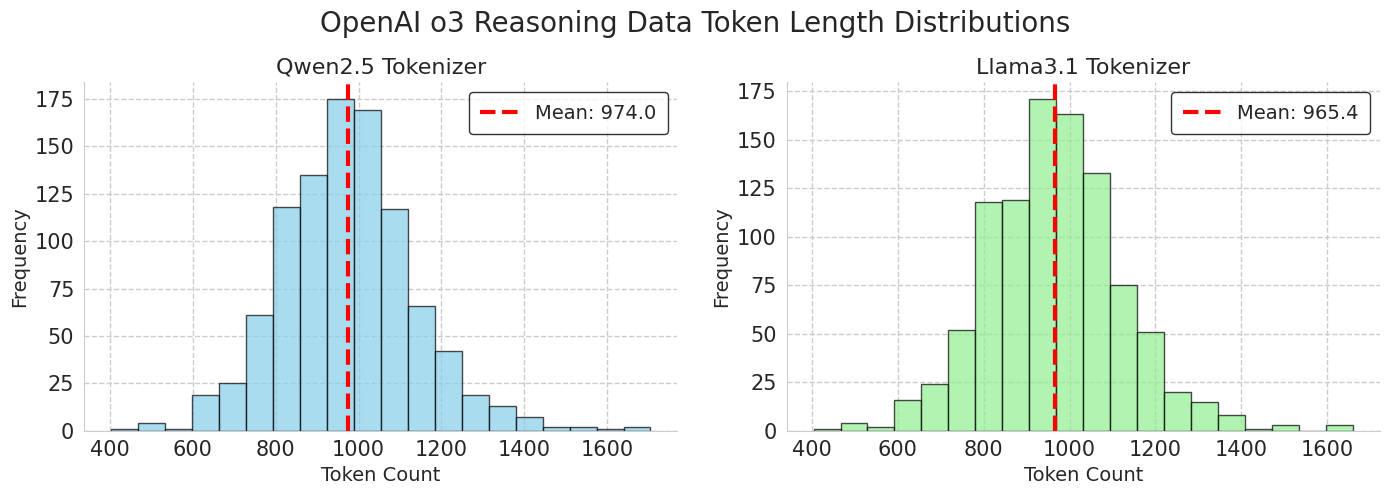

In [4]:
# Optional: Create simple visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the plot style to match your reference
    sns.set_style('whitegrid')
    
    def simple_axis(ax):
        """Remove top and right spines for cleaner look"""
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # You can choose which columns to plot
    # cols = ['output', 'reasoning', 'combined']  # All three types
    cols = ['combined']  # Just combined if you prefer
    # titles = ['Output Only', 'Reasoning Only', 'Output + Reasoning']
    titles = ['o3 Reasoning']  # If using just combined
    
    # Create subplots: number of data types (rows) x 2 tokenizers (columns)
    fig, axes = plt.subplots(len(cols), 2, figsize=(14, 5))
    fig.suptitle('OpenAI o3 Reasoning Data Token Length Distributions', fontsize=20, y=0.98)
    
    # Handle case where there's only one row (need to reshape axes)
    if len(cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, (col, title) in enumerate(zip(cols, titles)):
        # Qwen (left column)
        df[f'qwen_{col}'].hist(bins=20, alpha=0.7, ax=axes[i, 0], color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'Qwen2.5 Tokenizer', fontsize=16)
        axes[i, 0].axvline(df[f'qwen_{col}'].mean(), color='red', linestyle='--', linewidth=3,
                          label=f'Mean: {df[f"qwen_{col}"].mean():.1f}')
        axes[i, 0].set_xlabel('Token Count', fontsize=14)
        axes[i, 0].set_ylabel('Frequency', fontsize=14)
        axes[i, 0].tick_params(axis='both', which='major', labelsize=15)
        axes[i, 0].legend(frameon=True, fontsize=14, facecolor='white', edgecolor='black', borderpad=0.6)
        axes[i, 0].grid(True, which='both', linestyle='--', linewidth=1.0, alpha=1.0)
        simple_axis(axes[i, 0])
        
        # Llama (right column)
        df[f'llama_{col}'].hist(bins=20, alpha=0.7, ax=axes[i, 1], color='lightgreen', edgecolor='black')
        axes[i, 1].set_title(f'Llama3.1 Tokenizer', fontsize=16)
        axes[i, 1].axvline(df[f'llama_{col}'].mean(), color='red', linestyle='--', linewidth=3,
                          label=f'Mean: {df[f"llama_{col}"].mean():.1f}')
        axes[i, 1].set_xlabel('Token Count', fontsize=14)
        axes[i, 1].set_ylabel('Frequency', fontsize=14)
        axes[i, 1].tick_params(axis='both', which='major', labelsize=15)
        axes[i, 1].legend(frameon=True, fontsize=14, facecolor='white', edgecolor='black', borderpad=0.6)
        axes[i, 1].grid(True, which='both', linestyle='--', linewidth=1.0, alpha=1.0)
        simple_axis(axes[i, 1])
    
    plt.tight_layout()
    
    # Save high-resolution PNG - publication quality
    plt.savefig('token_distributions_qwen_vs_llama.png', 
                dpi=600, 
                format='png', 
                bbox_inches='tight',
                pad_inches=0.1,
                facecolor='white',
                edgecolor='none')
    
    print("📊 Plot saved as 'token_distributions_qwen_vs_llama.png' (600 DPI)")
    
    plt.show()
    
except ImportError:
    print("\n📊 Install matplotlib and seaborn to see visualizations: pip install matplotlib seaborn")

#### Create dataset

In [6]:
# Simple Token Length Analysis for Chess Dataset
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer

# Load your JSON data
with open('/home/jovyan/chessLLM/verl/third_party/SkyThought/skythought/train/LLaMA-Factory/data/original_chess_reasoning.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)
    data = json_data["results"]

print(f"Loaded {len(data)} chess examples")

# Setup tokenizers for filtering (if you want to apply the same filter)
print("Loading tokenizers for filtering...")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")

# Filter out samples with >2000 tokens (same as before)
filtered_data = []
removed_count = 0

print("Filtering and creating concatenated dataset...")
print("Transformation: Wrapping reasoning_summary + original_output in single <think> tags")

for i, item in enumerate(data):
    # Extract texts
    original_output = item['output']
    reasoning_summary = item['reasoning_summary']
    
    # Remove only the opening <think> from original_output (keep </think> and everything after)
    output_without_opening_think = original_output
    if original_output.startswith('<think>'):
        # Remove just the opening <think> tag
        output_without_opening_think = original_output[7:]  # 7 is len('<think>')
    
    # Create the new concatenated output format: <think>reasoning + original_without_opening_think
    concatenated_output = f"<think>\n{reasoning_summary}\n\n\n{output_without_opening_think}"
    
    # Check if the concatenated version exceeds 2000 tokens
    qwen_tokens = len(qwen_tokenizer.encode(concatenated_output))
    llama_tokens = len(llama_tokenizer.encode(concatenated_output))
    
    max_tokens = max(qwen_tokens, llama_tokens)
    
    # Only keep samples where concatenated output is ≤ 2000 tokens
    if max_tokens <= 2000:
        # Create new format
        new_item = {
            "instruction": item.get("instruction", ""),
            "input": item.get("input", ""),
            "output": concatenated_output,
            "system": item.get("system", "")
        }
        filtered_data.append(new_item)
    else:
        removed_count += 1

print(f"Filtered concatenated dataset: {len(filtered_data)} chess examples")
print(f"Removed: {removed_count} samples (concatenated output exceeded 2000 tokens)")
print(f"Retention rate: {len(filtered_data)/len(data)*100:.1f}%")

# Save the new concatenated dataset
output_filename = 'concatenated_chess_reasoning_dataset.json'
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(filtered_data, f, indent=2, ensure_ascii=False)

print(f"✅ Saved concatenated dataset to '{output_filename}'")

# Show a sample of the new format
print(f"\n📋 SAMPLE OF NEW FORMAT:")
print("=" * 80)
sample = filtered_data[0]
print(f"Instruction: {repr(sample['instruction'])}")
print(f"Input: {sample['input'][:100]}..." if len(sample['input']) > 100 else f"Input: {sample['input']}")
print(f"\nOutput structure:")
print(f"  - Starts with: <think>")
print(f"  - Contains reasoning summary")
print(f"  - Two newlines")
print(f"  - Then the original output (with <think> and <answer> tags)")
print(f"  - Ends with: </think>")
print(f"\nOutput (first 300 chars): {sample['output'][:300]}...")
print(f"System: {sample['system'][:100]}..." if len(sample['system']) > 100 else f"System: {sample['system']}")

# Analyze token statistics for the new format
print(f"\n📊 TOKEN STATISTICS FOR CONCATENATED FORMAT:")
print("=" * 80)

qwen_tokens = []
llama_tokens = []

for item in filtered_data:
    qwen_count = len(qwen_tokenizer.encode(item['output']))
    llama_count = len(llama_tokenizer.encode(item['output']))
    qwen_tokens.append(qwen_count)
    llama_tokens.append(llama_count)

# Statistics
import numpy as np

print(f"\n🔤 QWEN TOKENIZER (Concatenated Output):")
print(f"  Mean: {np.mean(qwen_tokens):.1f}")
print(f"  Median: {np.median(qwen_tokens):.1f}")
print(f"  Std: {np.std(qwen_tokens):.1f}")
print(f"  Min: {np.min(qwen_tokens)}")
print(f"  Max: {np.max(qwen_tokens)}")
print(f"  Q75: {np.percentile(qwen_tokens, 75):.1f}")
print(f"  Q95: {np.percentile(qwen_tokens, 95):.1f}")

print(f"\n🦙 LLAMA TOKENIZER (Concatenated Output):")
print(f"  Mean: {np.mean(llama_tokens):.1f}")
print(f"  Median: {np.median(llama_tokens):.1f}")
print(f"  Std: {np.std(llama_tokens):.1f}")
print(f"  Min: {np.min(llama_tokens)}")
print(f"  Max: {np.max(llama_tokens)}")
print(f"  Q75: {np.percentile(llama_tokens, 75):.1f}")
print(f"  Q95: {np.percentile(llama_tokens, 95):.1f}")

# Create comparison table
comparison_data = [{
    'Tokenizer': 'Qwen',
    'Mean': f"{np.mean(qwen_tokens):.1f}",
    'Median': f"{np.median(qwen_tokens):.1f}",
    'Std': f"{np.std(qwen_tokens):.1f}",
    'Min': np.min(qwen_tokens),
    'Max': np.max(qwen_tokens),
    'Q75': f"{np.percentile(qwen_tokens, 75):.1f}",
    'Q95': f"{np.percentile(qwen_tokens, 95):.1f}"
}, {
    'Tokenizer': 'Llama',
    'Mean': f"{np.mean(llama_tokens):.1f}",
    'Median': f"{np.median(llama_tokens):.1f}",
    'Std': f"{np.std(llama_tokens):.1f}",
    'Min': np.min(llama_tokens),
    'Max': np.max(llama_tokens),
    'Q75': f"{np.percentile(llama_tokens, 75):.1f}",
    'Q95': f"{np.percentile(llama_tokens, 95):.1f}"
}]

comparison_df = pd.DataFrame(comparison_data)

print(f"\n📈 CONCATENATED FORMAT COMPARISON TABLE:")
print("=" * 80)
print(comparison_df.to_string(index=False))

print(f"\n🎯 DATASET READY!")
print(f"File: {output_filename}")
print(f"Samples: {len(filtered_data)}")
print(f"Format: <think> + reasoning_summary + \\n\\n + original_output + </think>")
print(f"All samples ≤ 2000 tokens")

Loaded 983 chess examples
Loading tokenizers for filtering...
Filtering and creating concatenated dataset...
Transformation: Wrapping reasoning_summary + original_output in single <think> tags
Filtered concatenated dataset: 979 chess examples
Removed: 4 samples (concatenated output exceeded 2000 tokens)
Retention rate: 99.6%
✅ Saved concatenated dataset to 'concatenated_chess_reasoning_dataset.json'

📋 SAMPLE OF NEW FORMAT:
Instruction: ''
Input: Current FEN string: 8/8/6K1/p6P/8/8/1k6/8 w - - 1 49
Legal moves: Kh7 Kg7 Kf7 Kh6 Kf6 Kg5 Kf5 h6

Output structure:
  - Starts with: <think>
  - Contains reasoning summary
  - Two newlines
  - Then the original output (with <think> and <answer> tags)
  - Ends with: </think>

Output (first 300 chars): <think>
**Analyzing FEN string**

I'm looking at the current FEN string: "8/8/6K1/p6P/8/8/1k6/8 w - - 1 49", which indicates it's White's move at move number 49. First, I note that rank 8 is empty, and rank 7 is also empty. For rank 6, "6K1" revea

In [7]:
po = "<think>\n**Parsing FEN data**\n\nI'm working on parsing the FEN string: \"r2r2k1/pp1b1p1p/3np1pb/3pN3/5P2/2P1BBqP/PP4P1/R1Q1R1K1 w - - 11 20.\" \n\nFirst, analyzing the rank 8. It tells me the squares contain a black rook on a8, two on d8, and a black king on g8. \n\nRow 7 shows black pawns and a bishop, while row 6 contains a black knight and a few empty squares. I need to clarify what the letter \"p1\" means—might indicate pawn positioning. Let’s keep going!\n\n**Analyzing chess position**\n\nI've decompressed the row 1 string 'R1Q1R1K1'—that gives me the positions for White's pieces on the board. So, the pieces are set up like this: King on g1, Queen on c1, rooks on a1 and e1, bishops on e3 and f3, a knight on e5, and a number of pawns. \n\nBlack has a king on g8, with its queen close by on g3. Now I need to evaluate potential moves for White considering the board layout. There are tactical options to explore!\n\n**Evaluating knight movement**\n\nI'm examining the move 20.Nxf7 for White. This places the knight on f7 where it forks the black rook on d8 and the bishop on h6, which is pretty significant! \n\nHowever, the black king can capture the knight on f7, so it’s essential to assess if that move is safe. The black king on g8 is positioned to capture the knight, but I need to confirm if f7 is under threat from another piece. It looks like I’m assessing whether the knight’s placement allows for strategic advantage or if it’s too risky to proceed!\n\n\n\nPosition assessment\n• Material: Black is up one pawn.  White: Q, RR, BB, N, 6 pawns.  Black: Q, RR, BB, N, 7 pawns.\n• Black’s queen on g3 is menacing the white king (g3–f2–e1 diagonal) and attacks the bishop on f3 and the f4-pawn.  \n• White’s knight on e5 is very active; the bishops on e3 & f3 control key diagonals.  \n• The critical question: can White neutralise the queen and simultaneously gain material?\n\nMain candidate moves\n1. Nxf7 – wins a pawn but after …Kxf7 the knight is lost and the attack evaporates.  White is simply down a piece.\n2. Nxd7 – trades the strong knight for the d7-bishop; after …Rxd7 Black keeps the extra pawn and the pressure.\n3. Bf2 – blocks the queen’s diagonal but allows …Qxf4 when Black keeps the pawn plus lasting pressure.\n4. Ng4 – aims at trapping the black queen.  All queen replies are bad:\n\n a) …Qxg4? 21 hxg4 – queen lost.\n\n b) …Qxh3? 21 gxh3 – queen lost.\n\n c) …Qxg2+? 21 Bxg2 – queen lost.\n\n d) …Bxf4 21 Bxf4 Qxf4 22 Qxf4 – queen lost.\n\n e) …Qh4 (best try) 21 Bf2!, and the queen is still in a net: the bishop now hits h4; after 21…Qe7 (only move) 22 Bxh4 Black’s queen is finally trapped.  \n\n f) …Qxe1+ 21 Qxe1 – queens are exchanged and White wins a rook (net gain of the exchange plus a pawn).\n\nAll variations leave White with at least a rook advantage; most win the queen outright.  \nNo other candidate move offers anything comparable.  Therefore 20 Ng4! is clearly best.\n\nConclusion\nPlay Ng4, threatening to win the over-extended queen and turning the game completely in White’s favour.\n</think>\n<answer>Ng4</answer>"
print(po)

<think>
**Parsing FEN data**

I'm working on parsing the FEN string: "r2r2k1/pp1b1p1p/3np1pb/3pN3/5P2/2P1BBqP/PP4P1/R1Q1R1K1 w - - 11 20." 

First, analyzing the rank 8. It tells me the squares contain a black rook on a8, two on d8, and a black king on g8. 

Row 7 shows black pawns and a bishop, while row 6 contains a black knight and a few empty squares. I need to clarify what the letter "p1" means—might indicate pawn positioning. Let’s keep going!

**Analyzing chess position**

I've decompressed the row 1 string 'R1Q1R1K1'—that gives me the positions for White's pieces on the board. So, the pieces are set up like this: King on g1, Queen on c1, rooks on a1 and e1, bishops on e3 and f3, a knight on e5, and a number of pawns. 

Black has a king on g8, with its queen close by on g3. Now I need to evaluate potential moves for White considering the board layout. There are tactical options to explore!

**Evaluating knight movement**

I'm examining the move 20.Nxf7 for White. This places the